In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report


measurements = pd.read_csv('exercise_data.csv')
measurements.head()

,timestampUtc,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,measurementId,activity,repetitions
0,2021-04-07 20:59:16.760,-0.010300,-0.055900,0.975700,0.6098,-0.7012,-0.7622,1,Push ups,41
1,2021-04-07 20:59:16.770,-0.010307,-0.055967,0.976327,0.6098,-0.6951,-0.7622,1,Push ups,41
2,2021-04-07 20:59:16.780,-0.010313,-0.056033,0.976953,0.6098,-0.6890,-0.7622,1,Push ups,41
3,2021-04-07 20:59:16.790,-0.010320,-0.056100,0.977580,0.6098,-0.6829,-0.7622,1,Push ups,41
4,2021-04-07 20:59:16.800,-0.010327,-0.056167,0.978207,0.6098,-0.6768,-0.7622,1,Push ups,41


In [55]:
# Taking every row from  each measurement and dividing it by its repetitions value
# f.e. -> measurementId = 1 got 41 repetitions, I'll divide this set into 41 parts

# Saving all measurementId's and repetitions that are in our .csv file
measurement_list = []
repetitions_list = []

measurements = measurements.drop('timestampUtc', axis = 1)

for index, row in measurements.iterrows():
    if measurement_list.count(int(row['measurementId']))==0:
        measurement_list.append(int(row['measurementId']))
        repetitions_list.append(int(row['repetitions']))


print(measurement_list)
print(repetitions_list)
print(len(measurement_list)==len(repetitions_list))

[1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28]
[41, 2, 10, 10, 10, 10, 7, 3, 14, 7, 99, 75, 102, 44, 22, 2, 252, 39, 2137, 1488, 9000, 1234]
True


In [56]:
amount = np.ones(len(measurement_list)+1, dtype=int)
measure_temp = [] # checking if we already counted for this measurement
iter = 0

for index, row in measurements.iterrows():
    if measure_temp.count(int(row['measurementId']))==0:
        iter += 1
        measure_temp.append(int(row['measurementId']))
    if measure_temp.count(int(row['measurementId']))>0:
        amount[iter] += 1

print(amount)

amount = np.delete(amount, 0, 0)
amount = amount.tolist()

[    1  1382  2639    15    15    15    15    15  2657  1328   515   786
   772  7710 15976  8795   506  1409 10379   781   776   772   510]


In [57]:
print(len(amount)==len(measurement_list)==len(repetitions_list))

True


In [58]:
# Dividing all measurements for each repetition (amount[x]/repetitions_list[x] - amount of rows for one repetition for measurement_list[x])
# f.e. - amount[0]/repetitions_list[0] would be an amount of rows for one push-up (rounded) (first object of measurement_list[0] class, which is push-up)
# and then next amount[0]/repetitions_list[0] for next object of this class and this will be repeated for repetition_list[0] times

classes = []
for index, row in measurements.iterrows():
    if classes.count(row['activity'])==0:
        classes.append(row['activity'])

In [59]:
print(classes)

['Push ups', 'Walking', 'Squats', 'Frontal elevation of arms', 'Jump front & back']


In [60]:
y = measurements['activity']
X = measurements.drop('activity', axis = 1)

In [61]:
# AKTUALNE - bez podziału na powtórzenia
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [62]:
print(y_train.value_counts())
print('*'*50)
print(y_test.value_counts())

Walking                      19642
Frontal elevation of arms    10250
Push ups                      9072
Jump front & back             1446
Squats                          12
Name: activity, dtype: int64
**************************************************
Walking                      8470
Frontal elevation of arms    4335
Push ups                     3851
Jump front & back             666
Squats                          2
Name: activity, dtype: int64


In [67]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [81]:
'''
PARAMS:
sol - solver (‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’)
max - max iterations
jobs - number of CPU cores used during the cross-validation loop
'''
def LogReg(sol = 'saga', max = 2000, jobs = 3):
    model = LogisticRegression(solver=sol, max_iter=max, n_jobs=jobs)
    model.fit(X_train, y_train)
    name = 'LogReg: {} solver, {} maximum number of iterations, {} CPU cores used'.format(sol, max, jobs)
    return model, name

In [82]:
from sklearn.naive_bayes import BernoulliNB
MODELS = []
NAMES = []
#model1 = BernoulliNB(binarize = 'float')

model_LogReg, name_LogReg = LogReg()
MODELS.append(model_LogReg)
NAMES.append(name_LogReg)


In [80]:
iter_names = 0

for model in MODELS:
    acc = model.score(X_test, y_test)
    print(NAMES[iter_names])
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    iter_names += 1

LogReg saga solver, 2000 maximum number of iterations, 3 CPU cores used
Test Accuracy: 86.84%


In [89]:
import seaborn as sns
def draw_confusion_matrix(model):

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    clr = classification_report(y_test, y_pred, labels=classes, target_names=classes)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=90)
    plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)


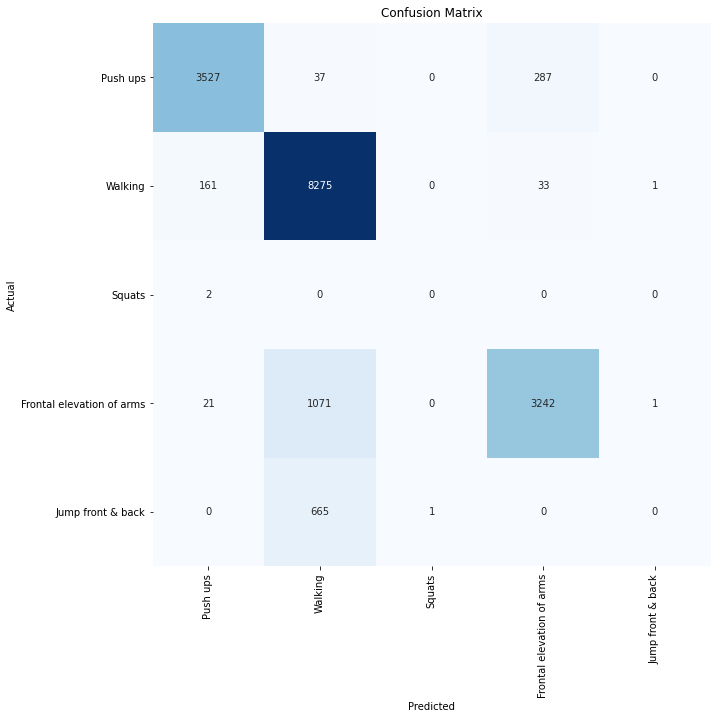

Classification Report:
----------------------
                            precision    recall  f1-score   support

                 Push ups       0.95      0.92      0.93      3851
                  Walking       0.82      0.98      0.89      8470
                   Squats       0.00      0.00      0.00         2
Frontal elevation of arms       0.91      0.75      0.82      4335
        Jump front & back       0.00      0.00      0.00       666

                 accuracy                           0.87     17324
                macro avg       0.54      0.53      0.53     17324
             weighted avg       0.84      0.87      0.85     17324



In [90]:
import seaborn as sns

draw_confusion_matrix(MODELS[0])
